In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
file_path_csv = '/content/drive/MyDrive/BTP: Novel Recipe Generation (Constraint Optimization) 2023/Data/Preprocessed/df_top5Balanced.csv'
df_balanced = pd.read_csv(file_path_csv)

In [4]:
# Print out the different regions in df_balanced
unique_regions = df_balanced['region'].unique()
print("Regions in df_balanced:", unique_regions)

Regions in df_balanced: ['Italian' 'Mexican' 'South American' 'Canadian' 'Indian Subcontinent']


In [5]:
batch_size = 100  # Adjust as needed

# Divide the DataFrame into batches
batches = np.array_split(df_balanced, len(df_balanced) // batch_size)

In [6]:
combined_embeddings = {}

for batch_idx in range(len(batches)):
    batch_file_path = f'/content/drive/MyDrive/BTP: Novel Recipe Generation (Constraint Optimization) 2023/Data/Preprocessed/embeddings_batch_{batch_idx}.pkl'
    with open(batch_file_path, 'rb') as f:
        batch_embeddings = pickle.load(f)
        combined_embeddings.update(batch_embeddings)

In [7]:
recipe_embeddings = combined_embeddings

In [8]:
len(recipe_embeddings)

32315

In [10]:
recipe_embeddings[4227]

array([-0.40579316, -0.33861515, -0.23383668, -0.25594616, -0.26205587,
       -0.27262205, -0.23252192, -0.17871618, -0.23810337, -0.22931719,
       -0.21527746, -0.2488691 , -0.2577688 , -0.24246383, -0.27759457,
       -0.22366667, -0.20127547, -0.24165122, -0.2061589 , -0.20502083,
       -0.24703728, -0.28432855, -0.265445  , -0.3007191 , -0.24921545,
       -0.22171837, -0.2757159 , -0.3192786 , -0.22469948, -0.17934814,
       -0.20374815, -0.23215473, -0.29260743, -0.28743052, -0.22982866,
       -0.21921852, -0.25324363, -0.24001507, -0.2522298 , -0.23469353,
       -0.19896832, -0.2763036 , -0.245925  , -0.25975865, -0.2926438 ,
       -0.2754583 , -0.30607936, -0.23058346, -0.2472181 , -0.28595293,
       -0.282383  , -0.362144  , -0.29931694, -0.2296472 , -0.21993265,
       -0.22342137, -0.25673538, -0.30647963, -0.26030606, -0.26581267,
       -0.3027267 , -0.29008788, -0.23981027, -0.16806227, -0.20175521,
       -0.33625492, -0.19770245, -0.27000767, -0.19089055, -0.23

In [12]:
# Count the number of recipe embeddings for each region
recipe_embedding_counts = {region: sum(df_balanced['ID'][df_balanced['region'] == region].isin(recipe_embeddings.keys())) for region in unique_regions}
print("Number of recipe embeddings for each region:", recipe_embedding_counts)

Number of recipe embeddings for each region: {'Italian': 6463, 'Mexican': 6463, 'South American': 6463, 'Canadian': 6463, 'Indian Subcontinent': 6463}


In [13]:
avg_embeddings = {}
for region in recipe_embedding_counts.keys():
    # Initialize sum array and count for the current region
    sum_embeddings = None
    count = 0

    # Iterate through the DataFrame rows
    for _, row in df_balanced.iterrows():
        if row['region'] == region and row['ID'] in recipe_embeddings:
            emb = recipe_embeddings[row['ID']]
            if sum_embeddings is None:
                sum_embeddings = np.zeros_like(emb)
            sum_embeddings += emb
            count += 1

    # Calculate average embeddings if embeddings were found
    if sum_embeddings is not None and count > 0:
        avg_embeddings[region] = sum_embeddings / count
    else:
        avg_embeddings[region] = None

In [16]:
# Compute cosine similarity matrix
regions = [region for region in avg_embeddings if avg_embeddings[region] is not None]
embeddings_list = []

for region in regions:
    embedding = avg_embeddings[region]
    # Ensure the embedding is a NumPy array
    if not isinstance(embedding, np.ndarray):
        embedding = np.array(embedding)
    embeddings_list.append(embedding)

# Check if embeddings_list is not empty and elements have the same shape
if embeddings_list and all(embedding.shape == embeddings_list[0].shape for embedding in embeddings_list):
    similarity_matrix = cosine_similarity(embeddings_list)
    print("Cosine Similarity Matrix:")
    print("Regions:", regions)
    print(similarity_matrix)
else:
    print("Error: Embeddings are not aligned or some regions have no embeddings.")

Cosine Similarity Matrix:
Regions: ['Italian', 'Mexican', 'South American', 'Canadian', 'Indian Subcontinent']
[[1.0000001  0.9999925  0.99999    0.9999188  0.9999945 ]
 [0.9999925  1.0000002  0.9999937  0.9999336  0.9999909 ]
 [0.99999    0.9999937  1.         0.99996006 0.999995  ]
 [0.9999188  0.9999336  0.99996006 1.         0.99994695]
 [0.9999945  0.9999909  0.999995   0.99994695 0.9999998 ]]


In [17]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random

# Number of iterations for averaging
num_iterations = 300

# Initialize a variable to sum the cosine similarity matrices
sum_similarity_matrix = None

for _ in range(num_iterations):
    selected_embeddings = []

    for region in ['Italian', 'Mexican', 'South American', 'Canadian', 'Indian Subcontinent']:
        # Filter embeddings for the current region
        region_embedding_ids = [id for id in df_balanced[df_balanced['region'] == region]['ID'] if id in recipe_embeddings]

        # Randomly select one embedding index
        if region_embedding_ids:
            selected_id = random.choice(region_embedding_ids)
            selected_embedding = recipe_embeddings[selected_id]
            selected_embeddings.append(selected_embedding)

    # Check if the correct number of embeddings are selected
    if len(selected_embeddings) == 5:  # 5 for five regions
        # Compute cosine similarity matrix for selected embeddings
        current_similarity_matrix = cosine_similarity(selected_embeddings)

        # Sum the similarity matrices
        if sum_similarity_matrix is None:
            sum_similarity_matrix = current_similarity_matrix
        else:
            sum_similarity_matrix += current_similarity_matrix

# Calculate the average cosine similarity matrix
average_similarity_matrix = sum_similarity_matrix / num_iterations

In [18]:
print("Average Cosine Similarity Matrix:")
# Print header
print(" " * 20, end="")  # Adjust spacing based on your needs
for region in regions:
    print(f"{region:>20}", end="")  # Format for better alignment
print()

# Print each row with the region label
for i, region_row in enumerate(regions):
    print(f"{region_row:>20}", end="")  # Region label
    for sim in average_similarity_matrix[i]:
        print(f"{sim:>20.4f}", end="")  # Similarity values formatted to 4 decimal places
    print()

Average Cosine Similarity Matrix:
                                 Italian             Mexican      South American            Canadian Indian Subcontinent
             Italian              1.0000              0.9890              0.9895              0.9902              0.9893
             Mexican              0.9890              1.0000              0.9897              0.9902              0.9895
      South American              0.9895              0.9897              1.0000              0.9908              0.9902
            Canadian              0.9902              0.9902              0.9908              1.0000              0.9907
 Indian Subcontinent              0.9893              0.9895              0.9902              0.9907              1.0000


### Clustering


10 clusters

In [19]:
from sklearn.cluster import KMeans

# Assuming recipe_embeddings is a dictionary with recipe IDs as keys and embeddings as values
embeddings = list(recipe_embeddings.values())  # Extracting embeddings

# Decide on the number of clusters
n_clusters = 10  # for example

# Perform clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)

# Getting cluster labels
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
# Assuming the index of df_balanced corresponds to the keys in recipe_embeddings
df_balanced['cluster'] = cluster_labels

In [21]:
# Group by cluster and then calculate the percentage of each region
cluster_region_distribution = df_balanced.groupby('cluster')['region'].value_counts(normalize=True) * 100

In [22]:
cluster_region_distribution

cluster  region             
0        Italian                22.710193
         Indian Subcontinent    20.784406
         South American         20.432128
         Mexican                18.576797
         Canadian               17.496477
1        Canadian               24.426736
         Indian Subcontinent    22.149943
         South American         19.954464
         Italian                18.637177
         Mexican                14.831680
2        Mexican                25.007884
         Canadian               22.075055
         South American         21.696626
         Italian                16.020183
         Indian Subcontinent    15.200252
3        Canadian               24.322943
         Indian Subcontinent    20.541645
         South American         19.672969
         Italian                18.242207
         Mexican                17.220235
4        Mexican                30.757014
         Canadian               21.704606
         South American         17.787189
     

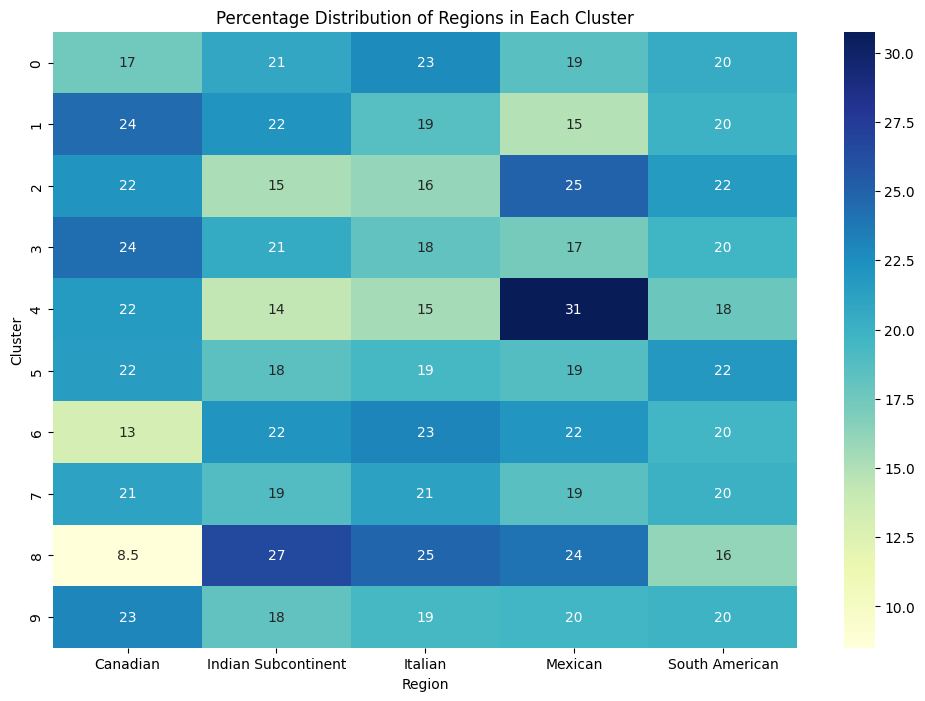

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Series to a DataFrame for easier plotting
cluster_region_distribution_df = cluster_region_distribution.reset_index(name='percentage')

# Pivot the DataFrame to have regions as columns and clusters as rows
pivot_df = cluster_region_distribution_df.pivot(index='cluster', columns='region', values='percentage').fillna(0)

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu")
plt.title('Percentage Distribution of Regions in Each Cluster')
plt.xlabel('Region')
plt.ylabel('Cluster')
plt.show()

5 clusters

In [24]:
from sklearn.cluster import KMeans

# Assuming recipe_embeddings is a dictionary with recipe IDs as keys and embeddings as values
embeddings = list(recipe_embeddings.values())  # Extracting embeddings

# Decide on the number of clusters
n_clusters = 5  # for example

# Perform clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)

# Getting cluster labels
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [25]:
# Assuming the index of df_balanced corresponds to the keys in recipe_embeddings
df_balanced['cluster'] = cluster_labels

In [26]:
# Group by cluster and then calculate the percentage of each region
cluster_region_distribution = df_balanced.groupby('cluster')['region'].value_counts(normalize=True) * 100

In [27]:
cluster_region_distribution

cluster  region             
0        Canadian               24.555264
         Indian Subcontinent    21.945174
         South American         19.830854
         Italian                18.518519
         Mexican                15.150190
1        Italian                20.970971
         South American         20.730731
         Mexican                20.560561
         Indian Subcontinent    19.179179
         Canadian               18.558559
2        Mexican                25.905292
         Indian Subcontinent    20.656795
         Italian                20.539510
         South American         18.091189
         Canadian               14.807213
3        Canadian               23.196938
         South American         19.988225
         Indian Subcontinent    19.134530
         Italian                19.075655
         Mexican                18.604651
4        Canadian               21.470756
         South American         21.318346
         Italian                19.984759
     

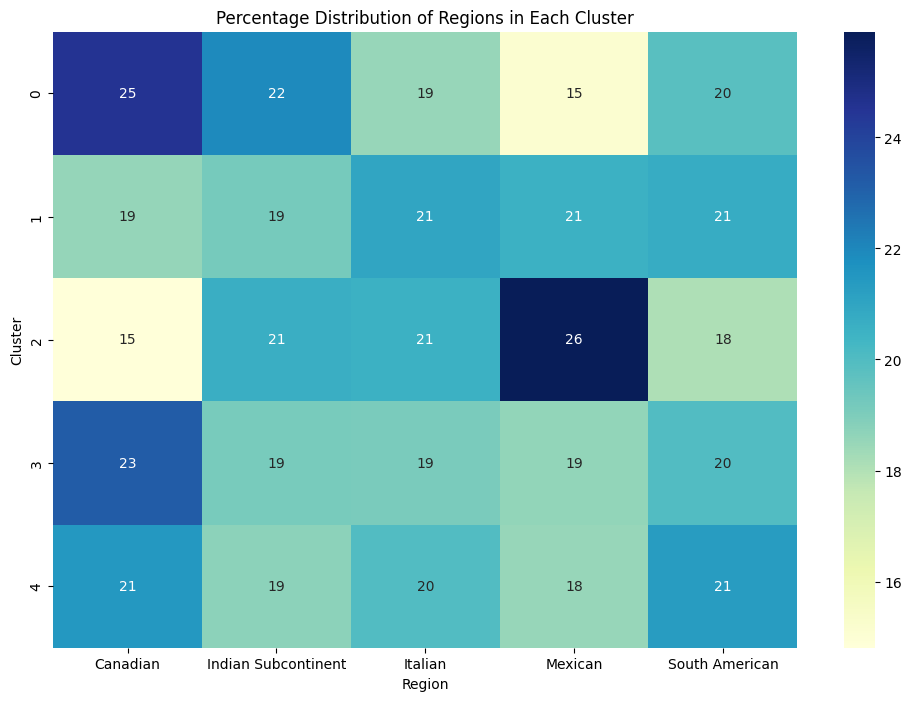

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Series to a DataFrame for easier plotting
cluster_region_distribution_df = cluster_region_distribution.reset_index(name='percentage')

# Pivot the DataFrame to have regions as columns and clusters as rows
pivot_df = cluster_region_distribution_df.pivot(index='cluster', columns='region', values='percentage').fillna(0)

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu")
plt.title('Percentage Distribution of Regions in Each Cluster')
plt.xlabel('Region')
plt.ylabel('Cluster')
plt.show()